# Transit Method
Of of the most successful methods to date for exoplanet discovery is the Transit Method. Basically, we are looking for when exoplanets eclipse (or transit) across the face of their stars. Here is a great overview of the method:
[https://www.paulanthonywilson.com/exoplanets/exoplanet-detection-techniques/the-exoplanet-transit-method/](https://www.paulanthonywilson.com/exoplanets/exoplanet-detection-techniques/the-exoplanet-transit-method/)

![Image of Transit Method](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-319-30648-3_117-1/MediaObjects/395338_0_En_117-1_Fig2_HTML.png)

## To exploit the shape of a transit (u-ish, v-ish shaped). There are currently two main period detection algorithms in use:

## 1) Box-fitting Least Squares (BLS)

## 2) Transit Least Squares (TLS)

Before we begin, lets take our fake light curve (See Intro to Python tutorial) and inject simulated planets into it.

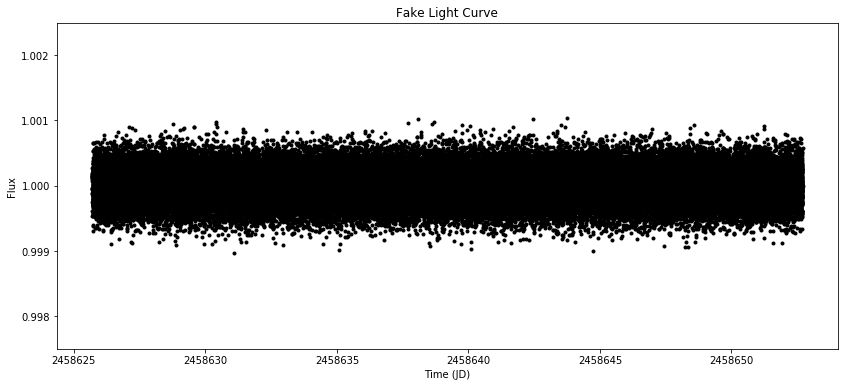

In [54]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pylab
from pylab import *

import time

fs=10 #fontsize for text in figures

ndays = 27 #days
cadence= 2*60 #take measurement twice an hour
pts_per_day = 24*cadence #data points per day
scatter_frac = 0.00025  # add scatter to data to make it realistic

start=0.0
stop=ndays
stepsize=ndays*pts_per_day
t = 2458625.7 + np.linspace(start, stop, stepsize) 

flux = 1.0 + np.random.randn(t.size) * scatter_frac
fluxerr = np.ones_like(flux) * scatter_frac

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(t,flux,marker='.',color='black',linestyle='none')
plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Fake Light Curve")
plt.ylim(0.9975,1.0025)
plt.show()

To inject fake planets into our data, we will be using the BATMAN Python module (included in the transitleastsquares installation). This module utilizes a Mandel-Agol transit model to fit transit events.

Read more about BATMAN here: [https://www.cfa.harvard.edu/~lkreidberg/batman/tutorial.html](https://www.cfa.harvard.edu/~lkreidberg/batman/tutorial.html)

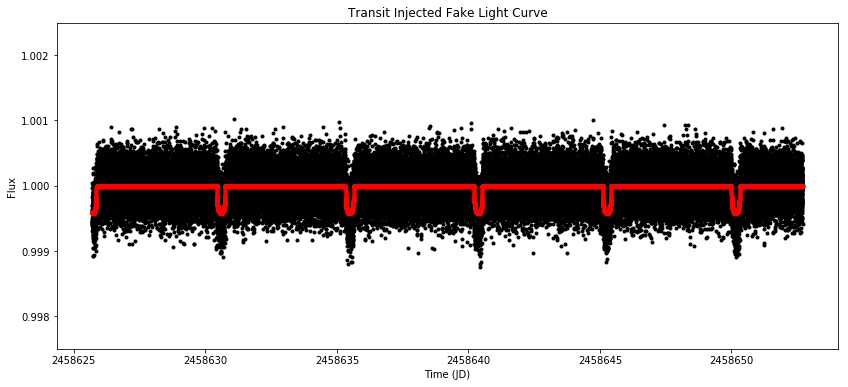

In [55]:
import batman

Rad_sun = 6.955*10.0**10.0 #cm
Rad_earth = 6.378*10.0**8.0 #cm
Mass_Sun = 1.989*10.0**33.0 #grams

time_start = t[0] #[0] =first data point in array

# Use batman to create transits
ma = batman.TransitParams()
ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
ma.per = 4.8910  # orbital period
ma.rp = 2.0*Rad_earth/Rad_sun  # planet radius (in units of stellar radii) 
ma.a = 5  # semi-major axis (in units of stellar radii)
ma.inc = 90  # orbital inclination (in degrees)
ma.ecc = 0  # eccentricity
ma.w = 90  # longitude of periastron (in degrees)
ma.u = [0.4, 0.4]  # limb darkening coefficients
ma.limb_dark = "quadratic"  # limb darkening model
m = batman.TransitModel(ma, t)  # initializes model
synthetic_signal = m.light_curve(ma)  # calculates light curve

injectedflux = synthetic_signal- flux+1

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(t,injectedflux,marker='.',color='black',linestyle='none')
plt.plot(t,synthetic_signal,marker='.',color='red',linestyle='none')
plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Transit Injected Fake Light Curve")
plt.ylim(0.9975,1.0025)
plt.show()

## First lets try applying BLS.

BLS works by searching a grid of different trial orbital periods and transit durations to see what shaped box best fits the data

In [56]:
# First lets make the grid

from astropy.stats import BoxLeastSquares
from transitleastsquares import period_grid

LCduration = t[-1]-t[0] #duration of light curve (last minus first data point)

# lets pick min/max of orbital period grid
minP=0.25;maxP = LCduration #orbital periods for grid

# lets pick min/max of transit duration grid
minT = 1.0/24.0; maxT = 5.0/24.0 # transit durations hours

#Lets make up values for our star
R_star = 0.15 # Solar radii
M_star = 0.12 # Solar masses

durations = np.linspace(minT, maxT, 25) #toy around with stepsize for run time optimization

periods = period_grid(R_star=R_star, M_star=M_star, time_span=LCduration, period_min=minP, period_max=maxP)#,oversampling_factor=10)



#start BLS search
bls = BoxLeastSquares(t, injectedflux) #just for specific target
bls_power = bls.power(periods, durations)
    
bls_SDE = (bls_power.power - np.mean(bls_power.power))/np.std(bls_power.power)

index = np.argmax(bls_power.power) #finds strongest peak in BLS power spectrum
BLS_periods=bls_power.period[index]
BLS_t0s=bls_power.transit_time[index]
BLS_depths=bls_power.depth[index]
dur = minT #0.5

bls_model=bls.model(t,bls_power.period[index], bls_power.duration[index], bls_power.transit_time[index])

# plt.figure(figsize=(15, 10))
# plt.plot(np.log10(bls_power.period), bls_SDE, "k")
# plt.axvline(np.log10(ma.per), color="grey", lw=8, alpha=0.5) #this is our injected transit period
# plt.annotate("period = {0:.4f} days".format(BLS_periods),(0, 1), xycoords="axes fraction",
#                         xytext=(50, -5), textcoords="offset points",va="top", ha="left", fontsize=12)
# plt.ylabel("SDE",fontsize=fs)
# plt.xlim(np.log10(periods.min())-0.1, np.log10(periods.max())+0.1)
# # plt.ylim(bls_SDE.min()-0.25, bls_SDE.max()+0.25)
# plt.xlabel("log(Period ( days))",fontsize=fs)
# plt.show()

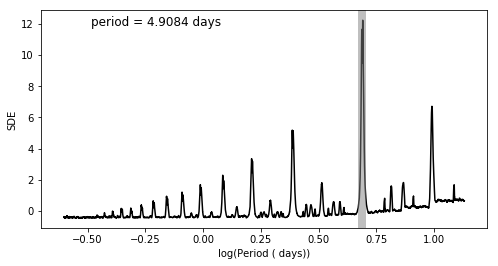

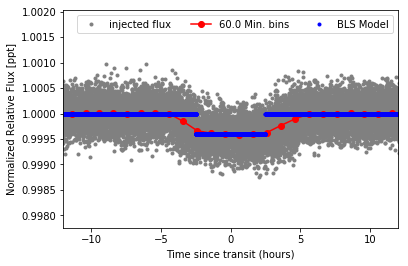

In [57]:
fs=10
plt.figure(figsize=(8, 4))
plt.plot(np.log10(bls_power.period), bls_SDE, "k")
plt.axvline(np.log10(ma.per), color="grey", lw=8, alpha=0.5) #this is our injected transit period
plt.annotate("period = {0:.4f} days".format(BLS_periods),(0, 1), xycoords="axes fraction",
                        xytext=(50, -5), textcoords="offset points",va="top", ha="left", fontsize=12)
plt.ylabel("SDE",fontsize=fs)
plt.xlim(np.log10(periods.min())-0.1, np.log10(periods.max())+0.1)
# plt.ylim(bls_SDE.min()-0.25, bls_SDE.max()+0.25)
plt.xlabel("log(Period ( days))",fontsize=fs)
plt.show()

# Plot the folded transit
p = BLS_periods
x_fold = (t - BLS_t0s + 0.5*p) % p - 0.5*p

#custom binning function
def Bin_func(time,flux,error,binsize):
    good = np.where(np.isfinite(time))
    timefit = time[good]
    fluxfit = flux[good]
    errfit  = error[good]
    timemax = np.max(timefit)
    timemin = np.min(timefit)
    npoints = len(timefit)
    nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days
    bintime = np.full((nbins,), np.nan)
    binflux = np.full((nbins,), np.nan)
    binerr  = np.full((nbins,), np.nan)
    for i in range(0,nbins-1):
        tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )]
        if tobin[0] != -1:
    #     inverse variance weighted means
            binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
    
    good2   = np.where(np.isfinite(bintime))
    bintime = bintime[good2]
    binflux = binflux[good2]
    binerr  = binerr[good2]
    
    return bintime, binflux, binerr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #these are annoying. 
binsize= 60.0/(60.0*24.0) 
bint,binf,binfe = Bin_func(x_fold, injectedflux,fluxerr,binsize)

plt.plot(24.0*x_fold, injectedflux, color='grey',marker=".",linestyle='none',label='injected flux')
plt. plot(24.0*bint, binf, color="r",marker='o',label=str(binsize*24*60)+' Min. bins') #hours
plt.plot(24.0*x_fold, bls_model, ".b",label='BLS Model') #hours

plt.xlim(-0.5*24.0, 0.5*24.0)
plt.ylim(np.min(injectedflux)-0.001, np.max(injectedflux)+0.001)  #just for specific target      
plt.ylabel("Normalized Relative Flux [ppt]",fontsize=fs)
plt.xlabel("Time since transit (hours)",fontsize=fs)
plt.legend(loc='upper right',ncol=3)
plt.show()

In [58]:
print("1")
print(1,"2",start)
print("hi"+" world",1," 2")


1
1 2 0.0
hi world 1  2


In [59]:
## Now lets try with TLS

In [60]:
from transitleastsquares import transitleastsquares
from transitleastsquares import catalog_info
from transitleastsquares import transit_mask



start = time.time()
# first we need limb-darkening coefficients
qld=[0.4,0.4]

#start TLS with same BLS inputs
model = transitleastsquares(t, injectedflux)
results = model.power(period_max=maxP,show_progress_bar=False)#,duration_grid_step=2)

#TLS results
TLS_periods=results.period
TLS_t0s=results.T0
TLS_depths=results.depth
TLS_SDE=results.power
    
#TLS results
phase_model = results.model_folded_phase
TLS_model = results.model_folded_model
phase = results.folded_phase
folded_y = results.folded_y


end = time.time()

runtime = end-start #seconds

print(" ")
print("runtime: ", runtime, "seconds")

Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 28 durations
Searching 77760 data points, 2459 periods from 0.601 to 13.5 days
Using all 4 CPU threads
 
runtime:  208.1334512233734 seconds


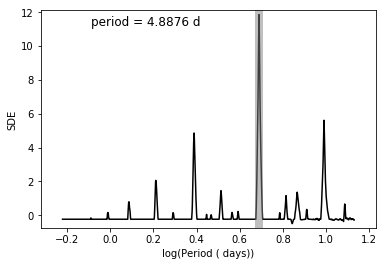

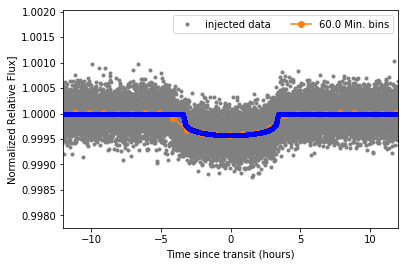

In [61]:
plt.plot(np.log10(results.periods), TLS_SDE, "k")
plt.axvline(np.log10(ma.per), color="grey", lw=8, alpha=0.5) #this is our injected transit period
plt.annotate("period = {0:.4f} d".format(results.period),(0, 1), xycoords="axes fraction",
                    xytext=(50, -5), textcoords="offset points",va="top", ha="left", fontsize=12)
plt.ylabel("SDE",fontsize=fs)
plt.xlim(np.log10(results.periods.min())-0.1, np.log10(results.periods.max())+0.1)
plt.ylim(TLS_SDE.min()-0.25, TLS_SDE.max()+0.25)
plt.xlabel("log(Period ( days))",fontsize=fs)
plt.show()

p = TLS_periods
x_fold = (t - TLS_t0s + 0.5*p) % p - 0.5*p
pf_model = (results.model_lightcurve_time - TLS_t0s + 0.5*p) % p - 0.5*p

plt.plot(24.0*x_fold, injectedflux, color='grey',marker=".",linestyle='none',label='injected data')
bint,binf,binfe = Bin_func(x_fold, injectedflux,fluxerr,binsize) #just for specific target
plt.plot(24.0*bint, binf, color="C1",marker='o',label=str(binsize*24*60)+' Min. bins') #hours
plt.plot(24.0*pf_model,results.model_lightcurve_model, "b.") #hours

plt.ylim(np.min(injectedflux)-0.001, np.max(injectedflux)+0.001)  #just for specific target      
plt.ylabel("Normalized Relative Flux]",fontsize=fs)
plt.xlabel("Time since transit (hours)",fontsize=fs)
plt.legend(loc='upper right',ncol=3)
plt.xlim(-0.5*24.0, 0.5*24.0)
plt.show()

In [62]:
# %reset 